In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
EPS = 7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
dset = Routes('train', 32, index_file='min-data.json').generator()
evalset = Routes('test', 32, index_file='min-data.json').generator()

Routes dataset: train
 [*] Loaded routes: 224 (0.25s)
 [*] Subset train: 204 (reserved_routes.json)
 [*] Loaded trainable inds: 240935 (0.21s)
Routes dataset: test
 [*] Loaded routes: 224 (0.28s)
 [*] Subset test: 20 (reserved_routes.json)
 [*] Loaded trainable inds: 54181 (0.02s)


In [5]:
from models.RNN import RNN

In [6]:
model = RNN(forecast=FORECAST, hidden_size=256).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
evaluate(evalset, model, criterion)

Eval loss: 32.13127895229119


In [9]:
losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    evaluate(evalset, model, criterion)
    torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/7 : 7530/7530] - L2.56         
Eval loss: 8.603557593003355
[2/7 : 7530/7530] - L3.81         
Eval loss: 8.638797191760053
[3/7 : 7530/7530] - L3.46         
Eval loss: 8.540215092397778
[4/7 : 7530/7530] - L2.93         
Eval loss: 8.520813645973115
[5/7 : 7530/7530] - L17.89        
Eval loss: 8.655541307810768


Process Process-69:
Process Process-68:
Process Process-67:
Process Process-70:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-71:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([d

KeyboardInterrupt: 

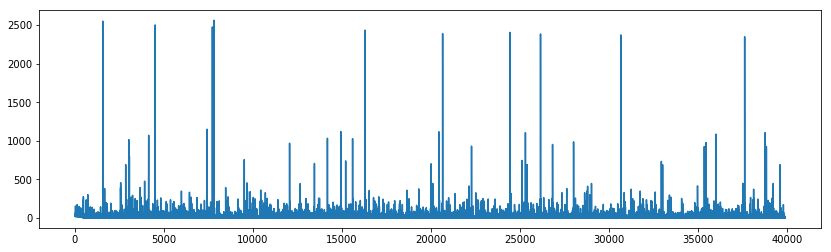

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(losses)
plt.show();plt.close()

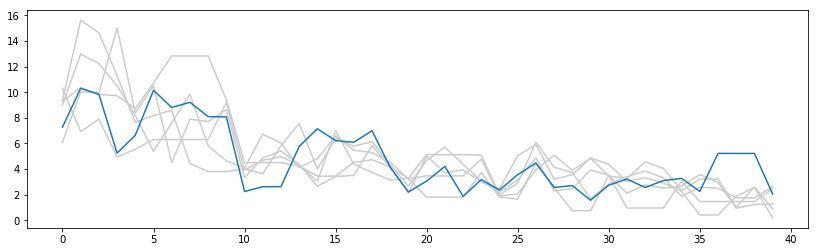

In [12]:
data = history_byname('Q10_0')

row_integs = []
for row in data:
    row_integs.append(np.count_nonzero(np.isnan(row)) / len(row))
ind = np.argsort(row_integs)[0]
sample = data[ind-6:ind, :]

plt.figure(figsize=(14, 4))
for hi in range(1, 6):
    plt.plot(sample[-hi-1, :], color='#CCCCCC')
plt.plot(sample[-1, :], color='C0')
plt.show(); plt.close()

In [13]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = sample[:, bi-10:bi].T
    Xs = np.expand_dims(hist, 1)
    Xs = torch.from_numpy(Xs).to(device).float()
    seqs = list(map(lambda vec: vec.squeeze(0), torch.split(Xs, 1)))
    seqs = list(reversed(seqs))

    yout = model(seqs)
    preds.append(tonpy(yout))

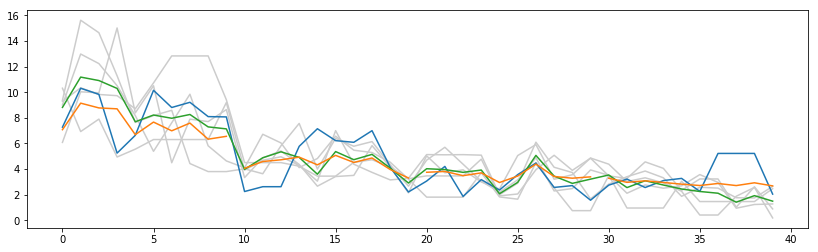

In [66]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 10):
    ylast = np.flip(preds[bi-10][:, 0, -1])
    xpos = list(range(bi-10, bi))
#     print(len(xpos), len(ylast))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()

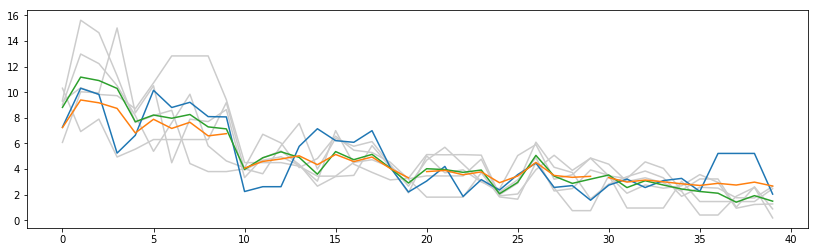

In [14]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 10):
    ylast = np.flip(preds[bi-10][:, 0, -1])
    xpos = list(range(bi-10, bi))
#     print(len(xpos), len(ylast))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()